In [4]:
from __future__ import print_function
from __future__ import division
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim.optimizer import Optimizer, required


In [5]:
class SVRG(Optimizer):
    r""" implement SVRG """ 

    def __init__(self, params, lr=required, freq =10):
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))

        defaults = dict(lr=lr, freq=freq)
        self.counter = 0
        self.counter2 = 0
        self.flag = False
        super(SVRG, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(SVRG, self).__setstate__(state)
        # for group in self.param_groups:
        #     group.setdefault('m', )

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            freq = group['freq']
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                param_state = self.state[p]
                
                if 'large_batch' not in param_state:
                    buf = param_state['large_batch'] = torch.zeros_like(p.data)
                    buf.add_(d_p) #add first large, low variance batch
                    #need to add the second term in the step equation; the gradient for the original step!
                    buf2 = param_state['small_batch'] = torch.zeros_like(p.data)

                buf = param_state['large_batch']
                buf2 = param_state['small_batch']

                if self.counter == freq:
                    buf.data = d_p.clone() #copy new large batch. Begining of new inner loop
                    temp = torch.zeros_like(p.data)
                    buf2.data = temp.clone()
                    
                if self.counter2 == 1:
                    buf2.data.add_(d_p) #first small batch gradient for inner loop!

                #dont update parameters when computing large batch (low variance gradients)
                if self.counter != freq and self.flag != False:
                    p.data.add_(-group['lr'], (d_p - buf2 + buf) )

        self.flag = True #rough way of not updating the weights the FIRST time we calculate the large batch gradient
        
        if self.counter == freq:
            self.counter = 0
            self.counter2 = 0

        self.counter += 1    
        self.counter2 += 1

        return loss

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
def eval_net(dataloader):
    correct = 0
    total = 0
    total_loss = 0
    net.eval() # Why would I do this?
    criterion = nn.CrossEntropyLoss(size_average=False)
    for data in dataloader:
        images, labels = data
        images, labels = Variable(images).cuda(), Variable(labels).cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.data).sum()
        loss = criterion(outputs, labels)
        total_loss += loss.item()
    net.train() # Why would I do this?
    return total_loss / total, correct / total
record=[]
if __name__ == "__main__":
    BATCH_SIZE = 32 #mini_batch size
    MAX_EPOCH = 10 #maximum epoch to train

    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #torchvision.transforms.Normalize(mean, std)

#     trainset = torchvision.datasets.CIFAR10(root='./data1', train=True,
#                                             download=False, transform=transform)
#     trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
#                                               shuffle=True, num_workers=2)

#     testset = torchvision.datasets.CIFAR10(root='./data1', train=False,
#                                            download=False, transform=transform)
#     testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
#                                              shuffle=False, num_workers=2)
    train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=False)
    test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)
 
    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    print('Building model...')
    net = Net().cuda()
    net.train() # Why would I do this?

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

    print('Start training...')
    for epoch in range(MAX_EPOCH):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data

            # wrap them in Variable
            inputs, labels = Variable(inputs).cuda(), Variable(labels).cuda()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.item()
            if i % 500 == 499:    # print every 2000 mini-batches
                print('    Step: %5d avg_batch_loss: %.5f' %
                      (i + 1, running_loss / 500))
                running_loss = 0.0
        record.append(running_loss)
        print('    Finish training this EPOCH, start evaluating...')
        train_loss, train_acc = eval_net(trainloader)
        test_loss, test_acc = eval_net(testloader)
        print('EPOCH: %d train_loss: %.5f train_acc: %.5f test_loss: %.5f test_acc %.5f' %
              (epoch+1, train_loss, train_acc, test_loss, test_acc))
    print('Finished Training')
    print('Saving model...')
    torch.save(net.state_dict(), 'mytraining.pth')


Building model...
Start training...
    Step:   500 avg_batch_loss: 1.98958
    Step:  1000 avg_batch_loss: 1.53117
    Step:  1500 avg_batch_loss: 1.30630
    Finish training this EPOCH, start evaluating...


/nfs/stak/users/wench/wen7/envs/myenv/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


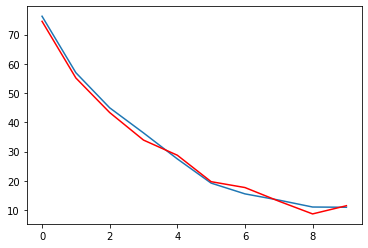

In [10]:
from matplotlib import pyplot as plt
plt.plot(record)
plt.plot(re2,color='red')

In [8]:
re2=[74.56247758865356,
 55.182134330272675,
 43.35601627826691,
 33.93928015232086,
 28.758339375257492,
 19.709520868957043,
 17.703631311655045,
 13.053175784647465,
 8.684506446123123,
 11.484037190675735]